Target: \
Improve the performance on test data and improve training stability by adding data augmentation.

Results: \
Parameters: 9,426 \
Best Train Accuracy: 99.40 \
Best Test Accuracy: 99.39 (99.41 in 8th epoch)

Analysis: \
No Overfitting on test data, performance on test data has improved by a margin. \
Training is not stable as accuracy of 99.41 was reached in 8th epoch but afterwards accuracy dropped.

# Import Libraries

In [ ]:
# load required libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

## Data Transformations


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                     ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1
batch_size = 64

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else \
                  dict(shuffle=True, batch_size=batch_size//2)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model

In [ ]:
# construct cnn class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 96, kernel_size = 5, padding = 2)  # apply 64 channel convolution with kernel size 5*5 on image
        self.conv2 = nn.Conv2d(96, 16, kernel_size = 1)  # apply 64 channel convolution with kernel size 1*1 on image
        self.conv3 = nn.Conv2d(16, 16, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image
        self.conv4 = nn.Conv2d(16, 8, kernel_size = 1)  # apply 64 channel convolution with kernel size 1*1 on image
        self.conv5 = nn.Conv2d(8, 16, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image
        self.conv6 = nn.Conv2d(16, 10, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image

        self.batch_norm1 = nn.BatchNorm2d(96)  # batch normalization after convolution layer 1
        self.batch_norm2 = nn.BatchNorm2d(16)  # batch normalization after convolution layer 2
        self.batch_norm3 = nn.BatchNorm2d(16)  # batch normalization after convolution layer 3
        self.batch_norm4 = nn.BatchNorm2d(8)  # batch normalization after convolution layer 4
        self.batch_norm5 = nn.BatchNorm2d(16)  # batch normalization after convolution layer 5

        self.dropout = nn.Dropout(0.05)

        self.gap = nn.AdaptiveAvgPool2d(1)


    def forward(self, img):
        x = F.relu(self.batch_norm1(self.conv1(img)))  # input = 1 * 28 * 28, output = 96 * 28 * 28, rf = 5*5
        x = F.relu(self.batch_norm2(self.conv2(x)))  # input = 96 * 28 * 28, output = 16 * 28 * 28, rf = 5*5
        x = F.max_pool2d(x, 2)  # input = 16 * 28 * 28, output = 16 * 14 * 14, rf = 6*6
        x = self.dropout(x)

        x = F.relu(self.batch_norm3(self.conv3(x)))  # input = 16 * 14 * 14, output = 16 * 12 * 12, rf = 10*10
        x = F.relu(self.batch_norm4(self.conv4(x)))  # input = 16 * 12 * 12, output = 8 * 12 * 12, rf = 10*10
        x = F.max_pool2d(x, 2)  # input = 8 * 12 * 12, output = 8 * 6 * 6, rf = 12*12
        x = self.dropout(x)
        
        x = F.relu(self.batch_norm5(self.conv5(x)))  # input = 8 * 6 * 6, output = 16 * 4 * 4, rf = 20*20
        x = self.conv6(x)  # input = 16 * 4 * 4, output = 10 * 2 * 2, rf = 28*28
        x = self.gap(x)  # input = 10 * 2 *2, output = 10 * 1 * 1, rf = 32*32
        x = x.view(-1, 10)  # flatten cnn embedding

        img_out = F.log_softmax(x, dim = 1)  # output layer to output probabilities for label

        return img_out

# Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 28, 28]           2,496
       BatchNorm2d-2           [-1, 96, 28, 28]             192
            Conv2d-3           [-1, 16, 28, 28]           1,552
       BatchNorm2d-4           [-1, 16, 28, 28]              32
           Dropout-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 16, 12, 12]           2,320
       BatchNorm2d-7           [-1, 16, 12, 12]              32
            Conv2d-8            [-1, 8, 12, 12]             136
       BatchNorm2d-9            [-1, 8, 12, 12]              16
          Dropout-10              [-1, 8, 6, 6]               0
           Conv2d-11             [-1, 16, 4, 4]           1,168
      BatchNorm2d-12             [-1, 16, 4, 4]              32

# Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, split="Test"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        split, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.05966421589255333 Batch_id=937 Accuracy=94.11: 100%|██████████| 938/938 [00:24<00:00, 37.71it/s]



Test set: Average loss: 0.0490, Accuracy: 9855/10000 (98.55%)

EPOCH: 1


Loss=0.06825853139162064 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:20<00:00, 45.72it/s]



Test set: Average loss: 0.0425, Accuracy: 9871/10000 (98.71%)

EPOCH: 2


Loss=0.009801664389669895 Batch_id=937 Accuracy=98.22: 100%|██████████| 938/938 [00:20<00:00, 45.72it/s]



Test set: Average loss: 0.0273, Accuracy: 9912/10000 (99.12%)

EPOCH: 3


Loss=0.0032393685542047024 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:20<00:00, 46.06it/s]



Test set: Average loss: 0.0289, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.009570731781423092 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:21<00:00, 43.80it/s]



Test set: Average loss: 0.0250, Accuracy: 9921/10000 (99.21%)

EPOCH: 5


Loss=0.06762854009866714 Batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [00:20<00:00, 44.99it/s]



Test set: Average loss: 0.0269, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.05752908065915108 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:21<00:00, 44.19it/s]



Test set: Average loss: 0.0225, Accuracy: 9930/10000 (99.30%)

EPOCH: 7


Loss=0.0074791088700294495 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:20<00:00, 45.11it/s]



Test set: Average loss: 0.0216, Accuracy: 9941/10000 (99.41%)

EPOCH: 8


Loss=0.050894275307655334 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:20<00:00, 45.48it/s]



Test set: Average loss: 0.0206, Accuracy: 9937/10000 (99.37%)

EPOCH: 9


Loss=0.020080821588635445 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:20<00:00, 45.31it/s]



Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


Loss=0.00800067838281393 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:20<00:00, 45.48it/s]



Test set: Average loss: 0.0236, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.024968568235635757 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:20<00:00, 45.15it/s]



Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.003664381103590131 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:20<00:00, 45.60it/s]



Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.03816790506243706 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:20<00:00, 45.54it/s]



Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.0032763141207396984 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:21<00:00, 43.03it/s]



Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)



# Final Model Performance

In [ ]:
test(model, device, train_loader, split = "Train")


Train set: Average loss: 0.0196, Accuracy: 59639/60000 (99.40%)



In [ ]:
test(model, device, test_loader, split = "Test")


Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)



# Performance Plots

Text(0.5, 1.0, 'Test Accuracy')

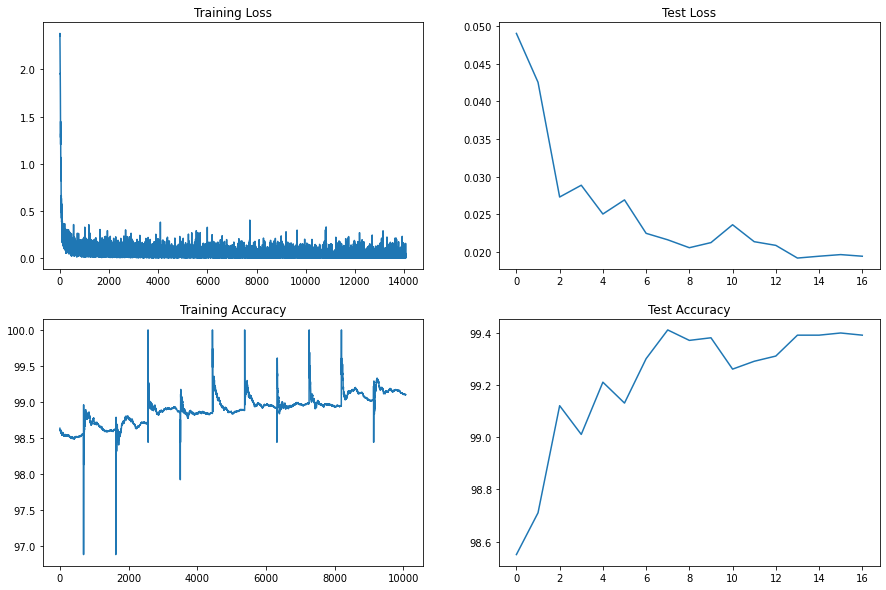

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")